In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import numpy as np
import torch
import cPickle as cp
import sys, os
sys.path.append("../../utils")
sys.path.append("../")

from data_loader import load_census_data, load_census_data_part
from plot_utils import get_colors
import rff
from rff import GaussianKernel, RFF
from kernel_regressor import Quantizer, KernelRidgeRegression
from bit_assignment import binary_search_bits_assignment
from pca_rff import PCA_RFF
import cPickle as cp
from misc_utils import Args

In [2]:
data_path = "../../../data/census/"

In [3]:
def load_census_data_part(path):
  X_test = np.load(path + "X_ho.npy")
  X_train = np.load(path + "X_tr.npy")
  Y_test = np.load(path + "Y_ho.npy")
  Y_train = np.load(path + "Y_tr.npy")
  X_test = X_test.item()['X_ho']
  X_train = X_train.item()['X_tr']
  Y_test = Y_test.item()['Y_ho']
  Y_train = Y_train.item()['Y_tr']
#   s = np.arange(X_train.shape[0] )
#   np.random.seed(0)
#   np.random.shuffle(s)
#   X_train = X_train[s, :]
#   Y_train = Y_train[s]
#   X_train, Y_train, X_test, Y_test = \
#     X_train[:(s.size * 1 / 3), :], Y_train[:(s.size * 1 / 3)], X_test[:(s.size * 1 / 3), :], Y_test[:(s.size * 1 / 3)]

#   X_train, Y_train, X_test, Y_test = \
#     X_train[:(s.size * 1 / 3), :], Y_train[:(s.size * 1 / 3)], X_test[:(s.size * 1 / 3), :], Y_test[:(s.size * 1 / 3)]
  return X_train, X_test, Y_train, Y_test

In [4]:
X_train, X_test, Y_train, Y_test = load_census_data_part(data_path)
n_input_feat = X_train.shape[1]
args = Args(n_fp_rff=1024, n_bit=8, 
            exact_kernel=True, reg_lambda=1e-3, 
            sigma=30.0, random_seed=1, 
            data_path=data_path, do_fp=False)

In [5]:
n_fp_feat_budget = 1024
F_norm_fp_rff_sqr = 217285107.943

In [6]:
# get a low precision PCA RFF
kernel = GaussianKernel(sigma=args.sigma)
kernel = PCA_RFF(args.n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed, mu=10.0)
kernel.setup(X_train, n_fp_feat_budget=n_fp_feat_budget, bits_upperbound=32)

('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


In [7]:
rff = kernel.get_cos_feat(X_train)
rff_test = kernel.get_cos_feat(X_test)
kernel_baseline = torch.mm(rff, torch.transpose(rff, 0, 1) )

In [8]:
# with open("./tmp/rotation_mat_U.npy", "w") as f:
#     np.save(f, kernel.U.cpu().numpy() )
with open("./tmp/rotation_mat_U.npy", "r") as f:
    U = np.load(f)
# with open("./tmp/original_rff.npy", "w") as f:
#     np.save(f, rff.cpu().numpy() )
with open("./tmp/original_rff.npy", "r") as f:
    rff = np.load(f)
# with open("./tmp/original_rff_test.npy", "w") as f:
#     np.save(f, rff_test.cpu().numpy() )
with open("./tmp/original_rff_test.npy", "r") as f:
    rff_test = np.load(f)
# with open("./tmp/kernel_baseline.npy", "w") as f:
#     np.save(f, kernel_baseline)

###  Verification row of ZU is a rotated feature representation

In [6]:
class Quantizer(object):
  def __init__(self, nbit, min_val, max_val, scale=None, rand_seed=1):
    self.nbit = nbit
    self.min_val = min_val
    self.max_val = max_val
    if scale == None:
      self.scale = (max_val - min_val) / float(2**self.nbit - 1)
    self.rand_seed = rand_seed

  def quantize_random(self, value, verbose=True):
#     value = torch.clamp(value, self.min_val, self.max_val)
    floor_val = self.min_val + torch.floor( (value - self.min_val) / self.scale) * self.scale
    ceil_val = self.min_val + torch.ceil( (value - self.min_val) / self.scale) * self.scale
    # print("test in the middle ", torch.min(floor_val), torch.max(ceil_val), self.min_val, self.max_val)
    # exit(0)
    floor_prob = (ceil_val - value) / self.scale
    ceil_prob = (value - floor_val) / self.scale
    # sanity check
    # np.testing.assert_array_almost_equal(floor_prob.cpu().numpy(), 
    #   1 - ceil_prob.cpu().numpy(), decimal=6)
    # if verbose:
    #   print("quantizer using random seed", self.rand_seed)
    np.random.seed(self.rand_seed)
    sample = torch.DoubleTensor(np.random.uniform(size=list(value.size() ) ) )
    # quant_val = floor_val * (sample < floor_prob).float() \
    #   + ceil_val * (sample >= floor_prob).float()
    quant_val = floor_val * (sample < floor_prob).double() \
      + ceil_val * (sample >= floor_prob).double()
    return quant_val

  def quantize(self, value, verbose=True):
    # TODO update if we have other quantization schemes
    return self.quantize_random(value, verbose)

### fixed bits results

('using regularior strength ', 1e-06)
('using regularior strength ', 1e-05)
('using regularior strength ', 0.0001)
('using regularior strength ', 0.001)
('using regularior strength ', 0.01)
('using regularior strength ', 0.1)
('using regularior strength ', 1.0)
[62777079.62791672, 62471005.78707943, 60061061.44827046, 52753338.918951005, 48980311.0014034, 56404859.928847186, 110759580.40813206]
('using regularior strength ', 1e-06)
('using regularior strength ', 1e-05)
('using regularior strength ', 0.0001)
('using regularior strength ', 0.001)
('using regularior strength ', 0.01)
('using regularior strength ', 0.1)
('using regularior strength ', 1.0)
[88172189.53180213, 82953447.76338667, 65717340.67324655, 49497661.031635806, 43020242.36019349, 50890464.32841943, 103041673.56885603]
('using regularior strength ', 1e-06)
('using regularior strength ', 1e-05)
('using regularior strength ', 0.0001)
('using regularior strength ', 0.001)
('using regularior strength ', 0.01)
('using regula

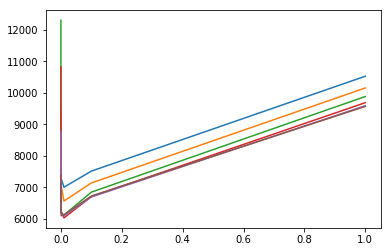

In [10]:
fixed_bits_results = {}
plt.figure()
for nbit in [32, 16, 8, 4, 2, 1]:
    n_quantized_rff = int(np.floor(args.n_fp_rff / float(nbit) * 32.0) )
    min_val = -np.sqrt(2.0/float(n_quantized_rff) )
    max_val = np.sqrt(2.0/float(n_quantized_rff) )
    quantizer_train = Quantizer(nbit, min_val, max_val, rand_seed=args.random_seed)
#     if not args.test_var_reduce:
    quantizer_test = quantizer_train
#     else:
#     quantizer_test = None
    kernel = GaussianKernel(sigma=args.sigma)
    n_input_feat = X_train.shape[1]
    kernel = RFF(n_quantized_rff, n_input_feat, kernel, rand_seed=args.random_seed)
    lamb_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
    error_list = []
    for lamb in lamb_list:
        regressor = KernelRidgeRegression(kernel, reg_lambda=lamb)
        regressor.fit(X_train, Y_train, quantizer=quantizer_train)
        pred = regressor.predict(X_test, quantizer_train=quantizer_train, quantizer_test=quantizer_test)
        test_error = regressor.get_test_error(Y_test)
        error_list.append(test_error)
    print error_list
    fixed_bits_results["fixed_" + str(nbit) ] = list(error_list)
    plt.plot(lamb_list, np.sqrt(error_list), label="fixed nbit " + str(nbit) )
plt.show()

In [11]:
with open("./tmp/fixed_bits_test_l2.pkl", "w") as f:
    cp.dump(fixed_bits_results, f)

In [12]:
with open("./tmp/fixed_bits_test_l2.pkl", "r") as f:
    fixed_bits_results = cp.load(f)

['fixed_16', 'fixed_32', 'fixed_8', 'fixed_1', 'fixed_2', 'fixed_4']


/afs/cs.stanford.edu/u/zjian/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


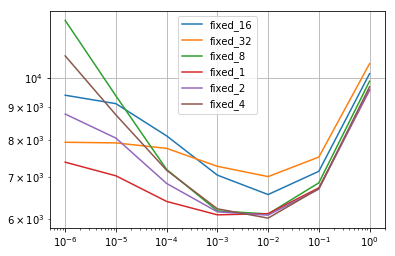

In [13]:
print fixed_bits_results.keys()
plt.figure()
for key in fixed_bits_results.keys():
    plt.plot(lamb_list, np.sqrt(fixed_bits_results[key] ), label=key)
ax = plt.subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend()
plt.show()

### l2 loss visualization generation

In [14]:
def plot_with_percentile(upper, lower, rff, rff_test):
    error_dict = {}
    for top_comp_rate in [0.01, 0.1, 1.0]: 
        plt.figure()
        kernel_approx_error_list = []
        for nbit in [16, 8, 4, 2, 1]:
            n_fp_rff = int(np.floor(args.n_fp_rff * 32.0 / float( (1 - top_comp_rate) * nbit + top_comp_rate * 32.0) ) ) 
            n_top_comp = int(np.floor(top_comp_rate * n_fp_rff) )
            print "n comp ", n_top_comp, "total ", n_fp_rff
            n_input_feat = X_train.shape[1]
            kernel = GaussianKernel(sigma=args.sigma)
            kernel = PCA_RFF(n_fp_rff, n_input_feat, kernel, rand_seed=args.random_seed, mu=10.0)
            # n_fp_feat_budget is dummy, we only want the PCA components
            kernel.setup(X_train, n_fp_feat_budget=n_fp_feat_budget, bits_upperbound=32)
            rff = kernel.get_cos_feat(X_train).cpu().numpy()
            rff_test = kernel.get_cos_feat(X_test).cpu().numpy()
            U = kernel.U.cpu().numpy()
            
            rff_offset = np.mean(rff, axis=0)
            rff_center = rff - rff_offset
            main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
            residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
            
            rff_center_test = rff_test - rff_offset
            main_comp_test = np.dot(rff_center_test, U[:, 0:n_top_comp])
            residual_test = rff_center_test - np.dot(main_comp_test, U[:, 0:n_top_comp].T)
            
            min_val = np.percentile(residual, q=lower, axis=0)
            max_val = np.percentile(residual, q=upper, axis=0)
            residual_clamp = np.clip(residual, min_val, max_val)
            residual_clamp_test = np.clip(residual_test, min_val, max_val)
            
            min_val = np.tile(np.percentile(residual, q=lower, axis=0).reshape(1, min_val.size), (rff.shape[0], 1) )
            max_val = np.tile(np.percentile(residual, q=upper, axis=0).reshape(1, max_val.size), (rff.shape[0], 1) )
            quantizer = Quantizer(nbit, torch.DoubleTensor(min_val), 
                                  torch.DoubleTensor(max_val), rand_seed=1)
            quant_residual = quantizer.quantize(torch.DoubleTensor(residual_clamp), verbose=False).cpu().numpy()
    #         quant_residual = residual
            recover_rff = np.dot(main_comp, U[:, 0:n_top_comp].T)
            recover_rff += quant_residual
            recover_rff += rff_offset        
            recover_kernel_mat = np.dot(recover_rff, recover_rff.T)
            
            quantizer = Quantizer(nbit, torch.DoubleTensor(min_val[:rff_test.shape[0], :]), 
                                  torch.DoubleTensor(max_val[:rff_test.shape[0], :]), rand_seed=1)
            quant_residual_test = quantizer.quantize(torch.DoubleTensor(residual_clamp_test), verbose=False).cpu().numpy()
    #         quant_residual = residual
            recover_rff_test = np.dot(main_comp_test, U[:, 0:n_top_comp].T)
            recover_rff_test += quant_residual_test
            recover_rff_test += rff_offset 
            
            
            error_list = []
            lamb_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
            for lamb in lamb_list:
                n_sample = recover_kernel_mat.shape[0]
                alpha = np.dot(np.linalg.inv( (recover_kernel_mat + lamb * np.eye(n_sample) ) ), Y_train)
                kernel_mat_pred = np.dot(recover_rff_test, recover_rff.T)
                prediction = np.dot(kernel_mat_pred, alpha)
                error = prediction - Y_test
                error_list.append(np.mean(error**2) )
            error_dict["top_comp_rate_" + str(top_comp_rate) + "_nbit_" + str(nbit) \
                       + "_upper_" + str(upper) + "_lower_" + str(lower) ] = list(error_list)
#             print("setting nbit best lambda", nbit, lamb_list[np.argmin(error_list) ] )
#             print("error list ", error_list)
            plt.plot(lamb_list, np.sqrt(error_list), label="top comp rate " + str(top_comp_rate) + " nbit " + str(nbit) )
        
        plt.grid()
        plt.legend()
        ax = plt.subplot(111)
        ax.set_yscale('log')
        ax.set_xscale('log')
        plt.show()
    return error_dict

n comp  20 total  2027
('found exact assignment plan', array([32, 32, 32, ...,  9,  9,  9]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  39 total  3976
('found exact assignment plan', array([28, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  76 total  7656
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  142 total  14246
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  250 total  25013
('found exact assignment plan', array([26, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


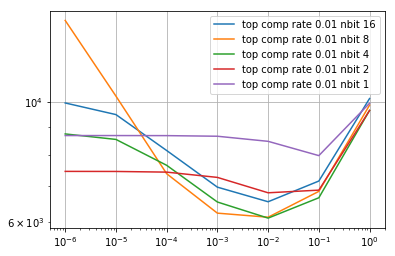

n comp  186 total  1861
('found exact assignment plan', array([32, 32, 32, ..., 11, 11, 11]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  315 total  3150
('found exact assignment plan', array([29, 28, 28, ...,  2,  2,  2]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  481 total  4818
('found exact assignment plan', array([27, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  655 total  6553
('found exact assignment plan', array([27, 27, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  799 total  7992
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


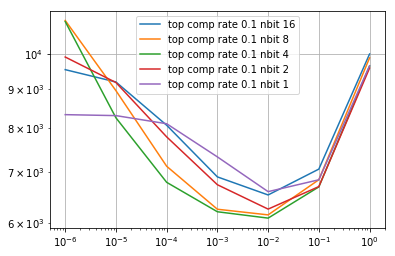

n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


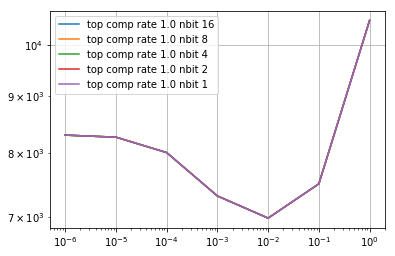

In [15]:
test_error_dict_100 = plot_with_percentile(upper=100, lower=0, rff=rff, rff_test=rff_test)

In [31]:
print test_error_dict_100.keys()
with open("./tmp/hybrid_upper_100_test_l2.pkl", "w") as f:
    cp.dump(test_error_dict_100, f)

['top_comp_rate_0.1_nbit_4_upper_100_lower_0', 'top_comp_rate_0.1_nbit_2_upper_100_lower_0', 'top_comp_rate_1.0_nbit_4_upper_100_lower_0', 'top_comp_rate_0.01_nbit_16_upper_100_lower_0', 'top_comp_rate_0.01_nbit_2_upper_100_lower_0', 'top_comp_rate_0.01_nbit_4_upper_100_lower_0', 'top_comp_rate_1.0_nbit_16_upper_100_lower_0', 'top_comp_rate_0.1_nbit_1_upper_100_lower_0', 'top_comp_rate_1.0_nbit_2_upper_100_lower_0', 'top_comp_rate_1.0_nbit_1_upper_100_lower_0', 'top_comp_rate_1.0_nbit_8_upper_100_lower_0', 'top_comp_rate_0.01_nbit_1_upper_100_lower_0', 'top_comp_rate_0.1_nbit_8_upper_100_lower_0', 'top_comp_rate_0.01_nbit_8_upper_100_lower_0', 'top_comp_rate_0.1_nbit_16_upper_100_lower_0']


n comp  20 total  2027
('found exact assignment plan', array([32, 32, 32, ...,  9,  9,  9]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  39 total  3976
('found exact assignment plan', array([28, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  76 total  7656
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  142 total  14246
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  250 total  25013
('found exact assignment plan', array([26, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


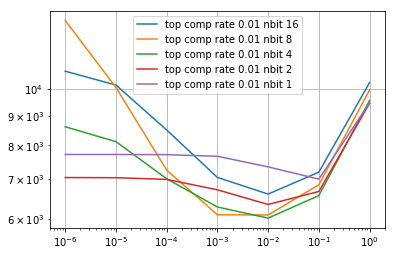

n comp  186 total  1861
('found exact assignment plan', array([32, 32, 32, ..., 11, 11, 11]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  315 total  3150
('found exact assignment plan', array([29, 28, 28, ...,  2,  2,  2]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  481 total  4818
('found exact assignment plan', array([27, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  655 total  6553
('found exact assignment plan', array([27, 27, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  799 total  7992
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


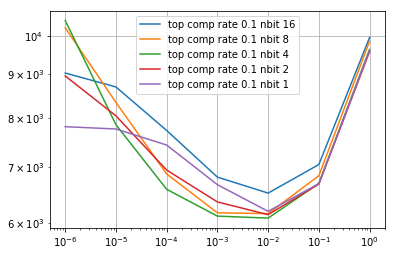

n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


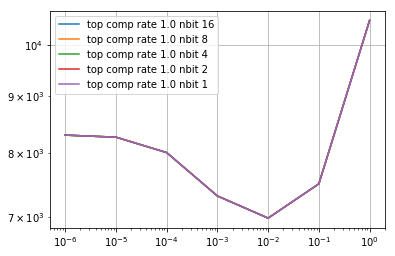

In [17]:
test_error_dict_999 = plot_with_percentile(upper=99.9, lower=0.1, rff=rff, rff_test=rff_test)

In [18]:
print test_error_dict_999.keys()
with open("./tmp/hybrid_upper_999_test_l2.pkl", "w") as f:
    cp.dump(test_error_dict_999, f)

['top_comp_rate_0.1_nbit_1_upper_99.9_lower_0.1', 'top_comp_rate_0.1_nbit_2_upper_99.9_lower_0.1', 'top_comp_rate_0.01_nbit_8_upper_99.9_lower_0.1', 'top_comp_rate_1.0_nbit_8_upper_99.9_lower_0.1', 'top_comp_rate_0.01_nbit_1_upper_99.9_lower_0.1', 'top_comp_rate_0.1_nbit_8_upper_99.9_lower_0.1', 'top_comp_rate_1.0_nbit_1_upper_99.9_lower_0.1', 'top_comp_rate_0.1_nbit_4_upper_99.9_lower_0.1', 'top_comp_rate_0.01_nbit_4_upper_99.9_lower_0.1', 'top_comp_rate_1.0_nbit_4_upper_99.9_lower_0.1', 'top_comp_rate_0.01_nbit_2_upper_99.9_lower_0.1', 'top_comp_rate_1.0_nbit_16_upper_99.9_lower_0.1', 'top_comp_rate_0.01_nbit_16_upper_99.9_lower_0.1', 'top_comp_rate_0.1_nbit_16_upper_99.9_lower_0.1', 'top_comp_rate_1.0_nbit_2_upper_99.9_lower_0.1']


n comp  20 total  2027
('found exact assignment plan', array([32, 32, 32, ...,  9,  9,  9]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  39 total  3976
('found exact assignment plan', array([28, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  76 total  7656
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  142 total  14246
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  250 total  25013
('found exact assignment plan', array([26, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


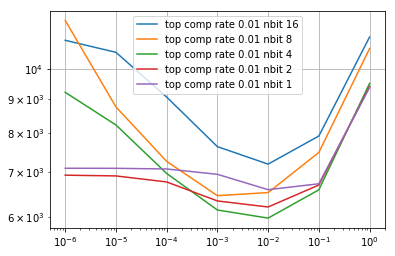

n comp  186 total  1861
('found exact assignment plan', array([32, 32, 32, ..., 11, 11, 11]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  315 total  3150
('found exact assignment plan', array([29, 28, 28, ...,  2,  2,  2]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  481 total  4818
('found exact assignment plan', array([27, 27, 27, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  655 total  6553
('found exact assignment plan', array([27, 27, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  799 total  7992
('found exact assignment plan', array([27, 26, 26, ...,  0,  0,  0]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


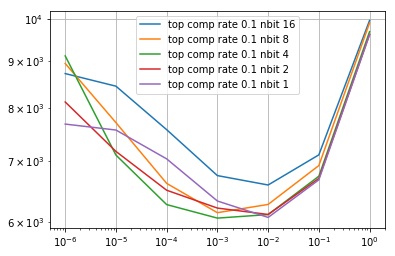

n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)
n comp  1024 total  1024
('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 1024.0, ' / ', 1024)


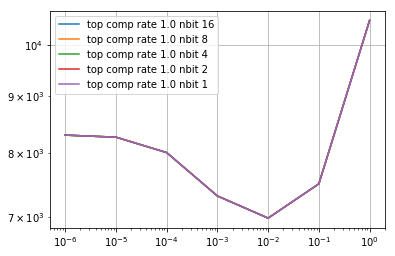

In [19]:
test_error_dict_99 = plot_with_percentile(upper=99.0, lower=1.0, rff=rff, rff_test=rff_test)

In [32]:
print test_error_dict_99.keys()
with open("./tmp/hybrid_upper_99_test_l2.pkl", "w") as f:
    cp.dump(test_error_dict_99, f)

['top_comp_rate_1.0_nbit_16_upper_99.0_lower_1.0', 'top_comp_rate_1.0_nbit_2_upper_99.0_lower_1.0', 'top_comp_rate_0.1_nbit_2_upper_99.0_lower_1.0', 'top_comp_rate_0.1_nbit_1_upper_99.0_lower_1.0', 'top_comp_rate_1.0_nbit_1_upper_99.0_lower_1.0', 'top_comp_rate_0.01_nbit_2_upper_99.0_lower_1.0', 'top_comp_rate_0.1_nbit_4_upper_99.0_lower_1.0', 'top_comp_rate_0.01_nbit_8_upper_99.0_lower_1.0', 'top_comp_rate_0.01_nbit_1_upper_99.0_lower_1.0', 'top_comp_rate_1.0_nbit_4_upper_99.0_lower_1.0', 'top_comp_rate_0.1_nbit_16_upper_99.0_lower_1.0', 'top_comp_rate_1.0_nbit_8_upper_99.0_lower_1.0', 'top_comp_rate_0.01_nbit_16_upper_99.0_lower_1.0', 'top_comp_rate_0.1_nbit_8_upper_99.0_lower_1.0', 'top_comp_rate_0.01_nbit_4_upper_99.0_lower_1.0']


### plot partial dataset

In [ ]:
with open("./tmp/fixed_bits_test_l2.pkl", "r") as f:
    fixed_bits_results = cp.load(f)
print fixed_bits_results.keys()

In [ ]:
with open("./tmp/hybrid_upper_100_test_l2.pkl", "r") as f:
    test_error_dict_100 = cp.load(f)

In [25]:
with open("./tmp/hybrid_upper_999_test_l2.pkl", "r") as f:
    test_error_dict_999 = cp.load(f)

In [34]:
with open("./tmp/hybrid_upper_99_test_l2.pkl", "r") as f:
    test_error_dict_99 = cp.load(f)

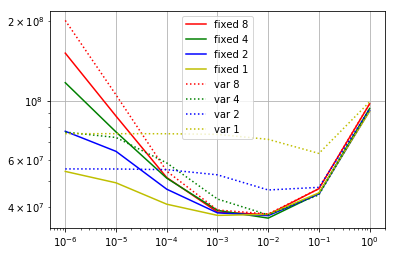

In [29]:
plt.figure()
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_8"] ), "r", label="fixed 8")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_4"] ), "g", label="fixed 4")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_2"] ), "b", label="fixed 2")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_1"] ), "y", label="fixed 1")  

plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_8_upper_100_lower_0"]), "r:", label="var 8")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_4_upper_100_lower_0"]), "g:", label="var 4")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_2_upper_100_lower_0"]), "b:", label="var 2")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_1_upper_100_lower_0"]), "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

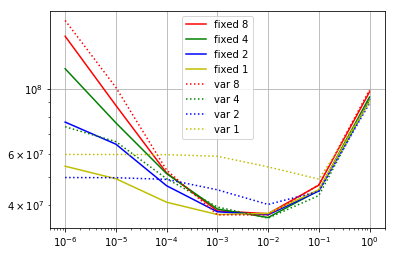

In [27]:
plt.figure()
plt.plot(lamb_list, fixed_bits_results["fixed_8"], "r", label="fixed 8")    
plt.plot(lamb_list, fixed_bits_results["fixed_4"], "g", label="fixed 4")    
plt.plot(lamb_list, fixed_bits_results["fixed_2"], "b", label="fixed 2")    
plt.plot(lamb_list, fixed_bits_results["fixed_1"], "y", label="fixed 1")  

plt.plot(lamb_list, test_error_dict_999["top_comp_rate_0.01_nbit_8_upper_99.9_lower_0.1"], "r:", label="var 8")    
plt.plot(lamb_list, test_error_dict_999["top_comp_rate_0.01_nbit_4_upper_99.9_lower_0.1"], "g:", label="var 4")    
plt.plot(lamb_list, test_error_dict_999["top_comp_rate_0.01_nbit_2_upper_99.9_lower_0.1"], "b:", label="var 2")    
plt.plot(lamb_list, test_error_dict_999["top_comp_rate_0.01_nbit_1_upper_99.9_lower_0.1"], "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

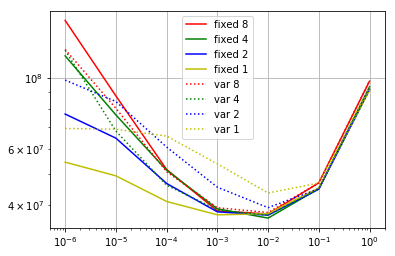

In [30]:
plt.figure()
plt.plot(lamb_list, fixed_bits_results["fixed_8"], "r", label="fixed 8")    
plt.plot(lamb_list, fixed_bits_results["fixed_4"], "g", label="fixed 4")    
plt.plot(lamb_list, fixed_bits_results["fixed_2"], "b", label="fixed 2")    
plt.plot(lamb_list, fixed_bits_results["fixed_1"], "y", label="fixed 1")  

plt.plot(lamb_list, test_error_dict_100["top_comp_rate_0.1_nbit_8_upper_100_lower_0"], "r:", label="var 8")    
plt.plot(lamb_list, test_error_dict_100["top_comp_rate_0.1_nbit_4_upper_100_lower_0"], "g:", label="var 4")    
plt.plot(lamb_list, test_error_dict_100["top_comp_rate_0.1_nbit_2_upper_100_lower_0"], "b:", label="var 2")    
plt.plot(lamb_list, test_error_dict_100["top_comp_rate_0.1_nbit_1_upper_100_lower_0"], "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

### plot full dataset

In [12]:
lamb_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]


In [13]:
with open("./tmp/fixed_bits_test_l2_full.pkl", "r") as f:
    fixed_bits_results = cp.load(f)
print fixed_bits_results.keys()

['fixed_16', 'fixed_32', 'fixed_8', 'fixed_1', 'fixed_2', 'fixed_4']


In [14]:
with open("./tmp/hybrid_upper_100_test_l2_full.pkl", "r") as f:
    test_error_dict_100 = cp.load(f)

In [15]:
with open("./tmp/hybrid_upper_999_test_l2_full.pkl", "r") as f:
    test_error_dict_999 = cp.load(f)

In [16]:
with open("./tmp/hybrid_upper_99_test_l2_full.pkl", "r") as f:
    test_error_dict_99 = cp.load(f)

/afs/cs.stanford.edu/u/zjian/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


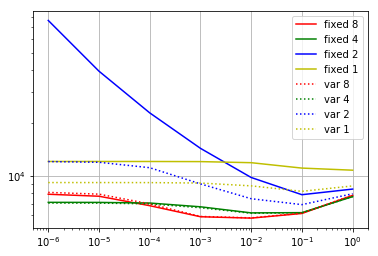

In [17]:
plt.figure()
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_8"] ), "r", label="fixed 8")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_4"] ), "g", label="fixed 4")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_2"] ), "b", label="fixed 2")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_1"] ), "y", label="fixed 1")  

plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_8_upper_100_lower_0"] ), "r:", label="var 8")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_4_upper_100_lower_0"] ), "g:", label="var 4")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_2_upper_100_lower_0"] ), "b:", label="var 2")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.01_nbit_1_upper_100_lower_0"] ), "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

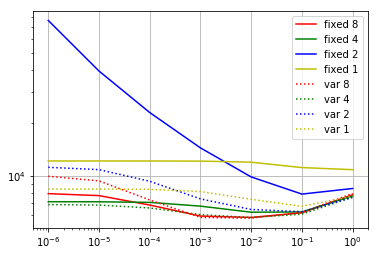

In [18]:
plt.figure()
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_8"] ), "r", label="fixed 8")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_4"] ), "g", label="fixed 4")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_2"] ), "b", label="fixed 2")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_1"] ), "y", label="fixed 1")  

plt.plot(lamb_list, np.sqrt(test_error_dict_999["top_comp_rate_0.01_nbit_8_upper_99.9_lower_0.1"] ), "r:", label="var 8")    
plt.plot(lamb_list, np.sqrt(test_error_dict_999["top_comp_rate_0.01_nbit_4_upper_99.9_lower_0.1"] ), "g:", label="var 4")    
plt.plot(lamb_list, np.sqrt(test_error_dict_999["top_comp_rate_0.01_nbit_2_upper_99.9_lower_0.1"] ), "b:", label="var 2")    
plt.plot(lamb_list, np.sqrt(test_error_dict_999["top_comp_rate_0.01_nbit_1_upper_99.9_lower_0.1"] ), "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

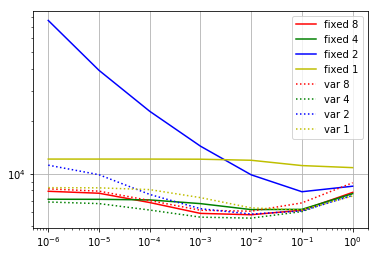

In [22]:
plt.figure()
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_8"] ), "r", label="fixed 8")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_4"] ), "g", label="fixed 4")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_2"] ), "b", label="fixed 2")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_1"] ), "y", label="fixed 1")  

plt.plot(lamb_list, np.sqrt(test_error_dict_99["top_comp_rate_0.01_nbit_8_upper_99.0_lower_1.0"] ), "r:", label="var 8")    
plt.plot(lamb_list, np.sqrt(test_error_dict_99["top_comp_rate_0.01_nbit_4_upper_99.0_lower_1.0"] ), "g:", label="var 4")    
plt.plot(lamb_list, np.sqrt(test_error_dict_99["top_comp_rate_0.01_nbit_2_upper_99.0_lower_1.0"] ), "b:", label="var 2")    
plt.plot(lamb_list, np.sqrt(test_error_dict_99["top_comp_rate_0.01_nbit_1_upper_99.0_lower_1.0"] ), "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

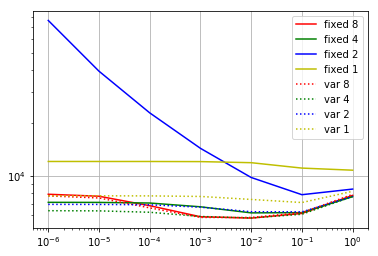

In [19]:
plt.figure()
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_8"] ), "r", label="fixed 8")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_4"] ), "g", label="fixed 4")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_2"] ), "b", label="fixed 2")    
plt.plot(lamb_list, np.sqrt(fixed_bits_results["fixed_1"] ), "y", label="fixed 1")  

plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.1_nbit_8_upper_100_lower_0"] ), "r:", label="var 8")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.1_nbit_4_upper_100_lower_0"] ), "g:", label="var 4")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.1_nbit_2_upper_100_lower_0"] ), "b:", label="var 2")    
plt.plot(lamb_list, np.sqrt(test_error_dict_100["top_comp_rate_0.1_nbit_1_upper_100_lower_0"] ), "y:", label="var 1")   
ax = plt.subplot(111)
ax.set_yscale("log")
ax.set_xscale("log")
plt.grid()
plt.legend()
plt.show()

### spectrum generation on the counterpart on server

In [58]:
def plot_with_percentile(upper, lower):
    spectrum_dict = {}
    plt.figure()
#     for n_top_comp in [0, ]:
    for n_top_comp in [0, 10, 100, 1000]:
        print "percent ", n_top_comp / float(rff.shape[0] )
        rff_offset = np.mean(rff, axis=0)
        rff_center = rff - rff_offset
        main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
        residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
#         dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
#         dy_range_1 = np.percentile(residual, q=99, axis=0) - np.percentile(residual, q=1, axis=0)
#         dy_range_10 = np.percentile(residual, q=90, axis=0) - np.percentile(residual, q=10, axis=0)

        kernel_approx_error_list = []
        for nbit in [1, 2, 4, 8, 16, 32]:
            min_val = np.percentile(residual, q=lower, axis=0)
            max_val = np.percentile(residual, q=upper, axis=0)
            residual_clamp = np.clip(residual, min_val, max_val)
#             print np.max(residual_clamp, axis=0), max_val
#             print np.min(residual_clamp, axis=0), min_val
            min_val = np.tile(np.percentile(residual, q=lower, axis=0).reshape(1, min_val.size), (rff.shape[0], 1) )
            max_val = np.tile(np.percentile(residual, q=upper, axis=0).reshape(1, max_val.size), (rff.shape[0], 1) )
            quantizer = Quantizer(nbit, torch.DoubleTensor(min_val), 
                                  torch.DoubleTensor(max_val), rand_seed=1)
            quant_residual = quantizer.quantize(torch.DoubleTensor(residual_clamp), verbose=False).cpu().numpy()
    #         quant_residual = residual
            recover_rff = np.dot(main_comp, U[:, 0:n_top_comp].T)
            recover_rff += quant_residual
            recover_rff += rff_offset        
            recover_kernel_mat = np.dot(recover_rff, recover_rff.T)
            kernel_approx_error = np.sum( (kernel_baseline.cpu().numpy() - recover_kernel_mat)**2)
            kernel_approx_error_list.append(kernel_approx_error)
            print "done bits ", nbit
#             _, S, _ = np.linalg.svd(recover_kernel_mat)
#             spectrum_dict["upper_" + str(upper) + "_n_top_" + str(n_top_comp) + "_nbit_" + str(nbit) ] = S
        plt.plot(np.sqrt(np.array(kernel_approx_error_list) / F_norm_fp_rff_sqr), label="n top comp " + str(n_top_comp) )
    #         print kernel_baseline.cpu().numpy().ravel()[:20]
    #         print recover_kernel_mat.ravel()[:20]
    #         raw_input()
        print "n top comp ", n_top_comp, kernel_approx_error_list
    plt.grid()
    plt.legend()
    ax = plt.subplot(111)
    ax.set_yscale('log')
    plt.show()
    return spectrum_dict

In [11]:
# val_10 = [2445749.1793917837, 90983.05670742986, 3575.4054838067823, 11.884725505977123, 0.00018462084635229321, 4.2366721601303593e-14]
# val_100 = [755943.12067424238, 39491.256157772084, 1583.0134186175358, 5.3615856278197169, 8.2026551445892452e-05, 1.8832408799369611e-14]
# val_1000 = [32.974419743918432, 3.1134650391946259, 0.10061072304108232, 0.00034411362396194939, 5.2218140425769637e-09, 1.2198138807298336e-18]

In [ ]:
# plt.figure()
# plt.semilogy(np.sqrt(np.array(val_10) / 217285107.943), label="10")
# plt.semilogy(np.sqrt(np.array(val_100) / 217285107.943), label="100")
# plt.semilogy(np.sqrt(np.array(val_1000) / 217285107.943), label="1000")
# plt.grid()
# plt.show()

percent  0.0
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  0 [692254.60837380437, 59036.068149258892, 2601.4393407446955, 9.7645520933268291, 0.00015335881714404352, 3.5399873621569562e-14]
percent  0.000610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  10 [2445749.1793917837, 90983.05670742986, 3575.4054838067823, 11.884725505977123, 0.00018462084635229321, 4.2366721601303593e-14]
percent  0.00610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  100 [755943.12067424238, 39491.256157772084, 1583.0134186175358, 5.3615856278197169, 8.2026551445892452e-05, 1.8832408799369611e-14]
percent  0.0610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  1000 [32.974419743918432, 3.1134650391946259, 0.10061072304108232, 0.00034411362396194939, 5.2218140425769637e-09, 1.2198138807298336e-18]


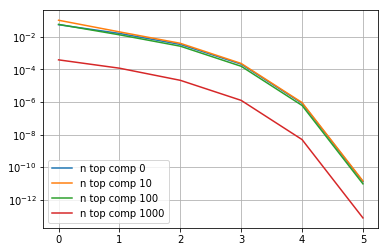

In [59]:
spectrum_dict = plot_with_percentile(upper=100, lower=0)
# with open("./tmp/spectrums_upper_" + str(100) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

percent  0.0
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  0 [402613.78729010525, 164048.63128408897, 145512.08387421371, 144922.11039523015, 144935.68662130341, 144935.72201153028]
percent  0.000610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  10 [141814.60842320893, 29418.594516813078, 21289.406185746131, 20970.461687785148, 20970.875193285261, 20970.885882514529]
percent  0.00610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  100 [20583.364785993646, 2633.1181335750425, 1060.4433010711386, 996.34710261710541, 996.17790247920414, 996.17741690229002]
percent  0.0610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  1000 [4.6158058036183656, 0.42754200040804763, 0.023304447366409714, 0.0083242736928649062, 0.0082720431364059904, 0.0082720248806817647]


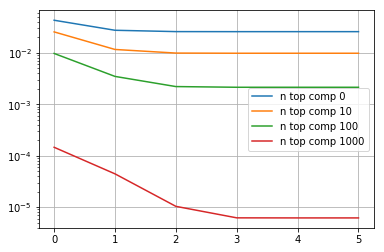

In [60]:
spectrum_dict = plot_with_percentile(upper=99, lower=1)
# with open("./tmp/spectrums_upper_" + str(99) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

percent  0.0
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  0 [2037910.3271958837, 2016209.1397601271, 2013963.8543712117, 2014121.3443208521, 2014128.0412932513, 2014128.0809346696]
percent  0.000610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  10 [87533.354665340477, 79217.684499009323, 78497.959467167311, 78476.145056256486, 78478.12688511351, 78478.13351083023]
percent  0.00610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  100 [4581.585388378795, 3688.3651566299804, 3590.1051688099042, 3592.4314400630269, 3592.4848657585439, 3592.4855886375963]
percent  0.0610985519643
done bits  1
done bits  2
done bits  4
done bits  8
done bits  16
done bits  32
n top comp  1000 [0.39614677496570816, 0.058488428074590329, 0.025235077756101894, 0.023864888331765675, 0.023864919679881063, 0.02386492280181424]


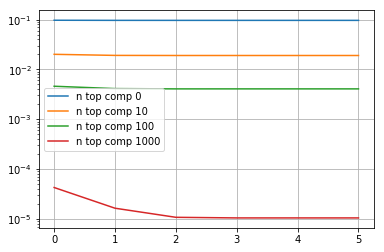

In [61]:
spectrum_dict = plot_with_percentile(upper=90, lower=10)
# with open("./tmp/spectrums_upper_" + str(90) + ".npy", "w") as f:
#     cp.dump(spectrum_dict, f)

percent  0.0


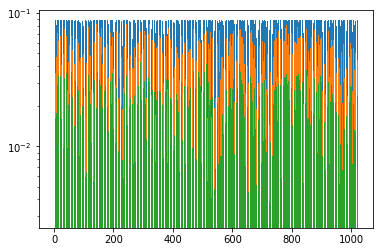

percent  0.000610985519643


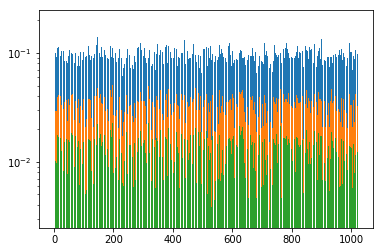

percent  0.00610985519643


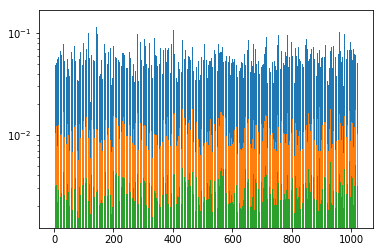

percent  0.0610985519643


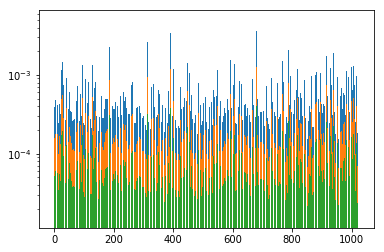

percent  0.610985519643


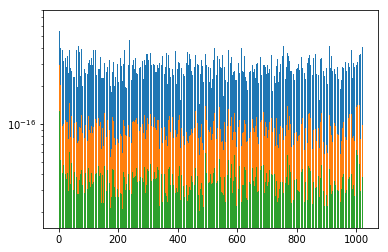

In [48]:
for n_top_comp in [0, 10, 100, 1000, 10000]:
    plt.figure()
    print "percent ", n_top_comp / float(rff.shape[0] )
    rff_offset = np.mean(rff, axis=0)
    rff_center = rff - rff_offset
    main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
    residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
    dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
    dy_range_1 = np.percentile(residual, q=99, axis=0) - np.percentile(residual, q=1, axis=0)
    dy_range_10 = np.percentile(residual, q=90, axis=0) - np.percentile(residual, q=10, axis=0)
    plt.bar(np.arange(dy_range.size), dy_range)
    plt.bar(np.arange(dy_range.size), dy_range_1)
    plt.bar(np.arange(dy_range.size), dy_range_10)
    ax = plt.subplot(111)
    ax.set_yscale("log")
    plt.show()    

### plot spectrums

In [62]:
with open("./tmp/spectrums_upper_" + str(100) + ".npy", "r") as f:
    spectrums_upper_100 = cp.load(f)
with open("./tmp/spectrums_upper_" + str(99) + ".npy", "r") as f:
    spectrums_upper_99 = cp.load(f)
with open("./tmp/spectrums_upper_" + str(90) + ".npy", "r") as f:
    spectrums_upper_90 = cp.load(f)
with open("./exact_kernel_spectrum.npy", "r") as f:
    spectrums_exact = np.load(f)
with open("./spectrum_rff_pca_sqr_with_l2_n_base_feat_1024.pkl", "r") as f:
    spectrums = cp.load(f)
spectrums_fp = spectrums["fp_rff_error"]
with open("./spectrum_rff_pca_sqr_with_l2_n_base_feat_8192.pkl", "r") as f:
    spectrums_fix_bit = cp.load(f)
# np.savetxt("./fp_rff_kernel_spectrum_1024.txt", spectrums["fp_rff_error"], delimiter=",")

In [28]:
print spectrums_upper_100.keys()

['upper_100_n_top_10_nbit_4', 'upper_100_n_top_10_nbit_2', 'upper_100_n_top_10_nbit_1', 'upper_100_n_top_10_nbit_8', 'upper_100_n_top_100_nbit_8', 'upper_100_n_top_100_nbit_4', 'upper_100_n_top_100_nbit_2', 'upper_100_n_top_100_nbit_1', 'upper_100_n_top_1000_nbit_8', 'upper_100_n_top_0_nbit_16', 'upper_100_n_top_1000_nbit_4', 'upper_100_n_top_1000_nbit_1', 'upper_100_n_top_1000_nbit_2', 'upper_100_n_top_10_nbit_16', 'upper_100_n_top_10_nbit_32', 'upper_100_n_top_1000_nbit_16', 'upper_100_n_top_0_nbit_2', 'upper_100_n_top_0_nbit_1', 'upper_100_n_top_0_nbit_4', 'upper_100_n_top_0_nbit_8', 'upper_100_n_top_100_nbit_16', 'upper_100_n_top_1000_nbit_32', 'upper_100_n_top_0_nbit_32', 'upper_100_n_top_100_nbit_32']


### plot upper 100 spectrum

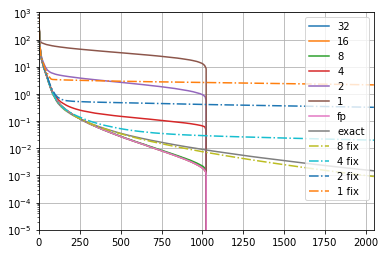

In [40]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_10_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

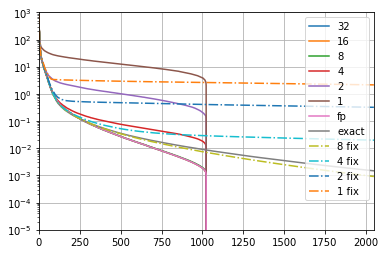

In [41]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_100_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

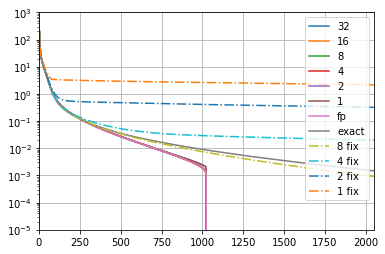

In [42]:
plt.figure()
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_100["upper_100_n_top_1000_nbit_2"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

### plot upper 99

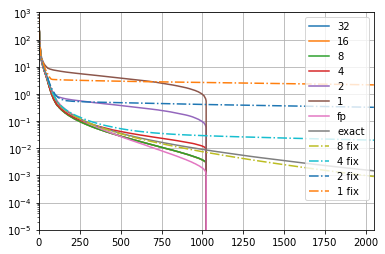

In [65]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_10_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

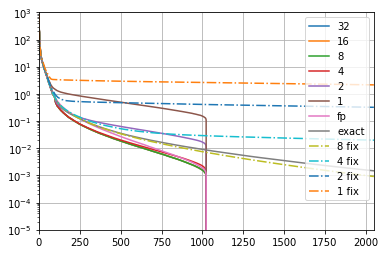

In [71]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_100_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

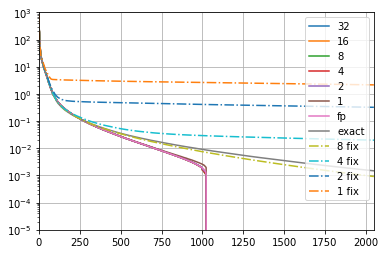

In [67]:
plt.figure()
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_99["upper_99_n_top_1000_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

### plot upper 90

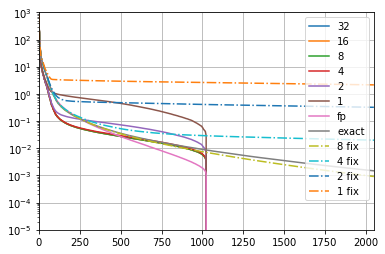

In [68]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_10_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

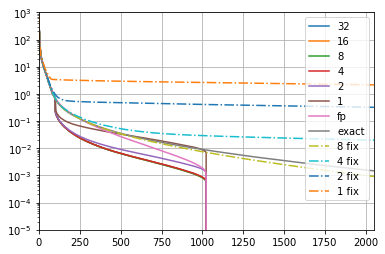

In [69]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_100_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

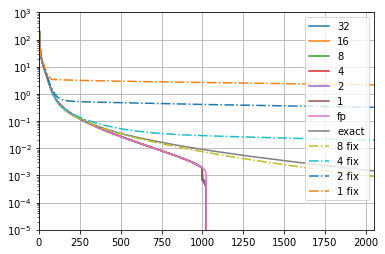

In [70]:
plt.figure()
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_32"], label="32")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_16"], label="16")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_8"], label="8")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_4"], label="4")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_2"], label="2")
plt.semilogy(spectrums_upper_90["upper_90_n_top_1000_nbit_1"], label="1")
plt.semilogy(spectrums_fp, label="fp")
plt.semilogy(spectrums_exact, label="exact")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_8_seed_1"], '-.', label="8 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_4_seed_1"], '-.', label="4 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_2_seed_1"], '-.', label="2 fix")
plt.semilogy(spectrums_fix_bit["lp_rff_budget_1024_nbit_1_seed_1"], '-.', label="1 fix")
plt.grid()
plt.legend()
plt.ylim([1e-5, 1e3])
plt.xlim([0, 2048])
plt.show()

In [41]:
n_top_comp = 0

<Container object of 1024 artists>

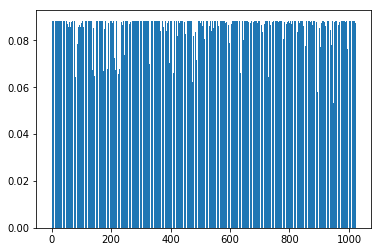

In [42]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)

In [33]:
n_top_comp = 100

<Container object of 1024 artists>

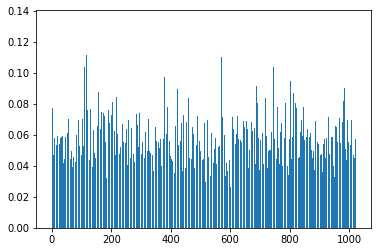

In [38]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)

In [39]:
n_top_comp = 1000

<Container object of 1024 artists>

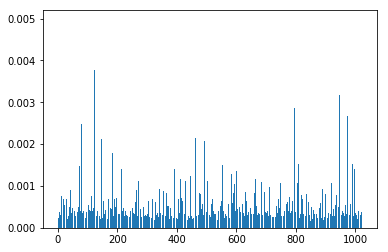

In [40]:
rff_center = rff - np.mean(rff, axis=0)
main_comp = np.dot(rff_center, U[:, 0:n_top_comp])
residual = rff_center - np.dot(main_comp, U[:, 0:n_top_comp].T)
dy_range = np.max(residual, axis=0) - np.min(residual, axis=0)
plt.bar(np.arange(dy_range.size), dy_range)